In [25]:
import yfinance as yf
import pandas as pd
import anaylsis
import datetime as dt
import matplotlib.pyplot as plt

In [26]:
end = dt.datetime.now(anaylsis.timezone)
start = dt.datetime(year=end.year - 10, month=end.month, day=end.day, tzinfo=anaylsis.timezone)

In [27]:
symbol="ABR"
initial_cash = 10000

In [28]:
ticker = yf.Ticker(symbol)
prices = ticker.history(start=start, end=end)
prices.index = pd.to_datetime(prices.index)
prices.index = prices.index.tz_convert(anaylsis.timezone)

In [29]:
div_events = anaylsis.gather_dividends(symbol, start, end)
current_event = div_events.iloc[-1]
dividend_period = current_event["frequency"]
f"Latest dividend is {current_event["cash_amount"]}. Dividends are paid {anaylsis.frequency_map.get(current_event["frequency"])}"

INFO:root:size: 42, ex_dividend_date: 2024-11-15, symbol: ABR


'Latest dividend is 0.43. Dividends are paid Quarterly'

In [30]:
div_events = anaylsis.trim_div_events(div_events, end)
snowball = anaylsis.dividend_snowball(prices, div_events, initial_cash)
snowball["value"] = snowball["Close"] * snowball["quantity"]

In [31]:
approaches = []

In [32]:
final_value = snowball.iloc[-1].value
approaches.append(anaylsis.create_approach_summary("Reinvest Dividends", final_value, initial_cash , 0.0))
dividends_gathered = anaylsis.dividend_keep_the_cash(prices, div_events, initial_cash)
final_value = dividends_gathered.iloc[-1].value
cash_in_bank = dividends_gathered.total_dividend.sum()
approaches.append(anaylsis.create_approach_summary("Keep the Cash", final_value, initial_cash, cash_in_bank))

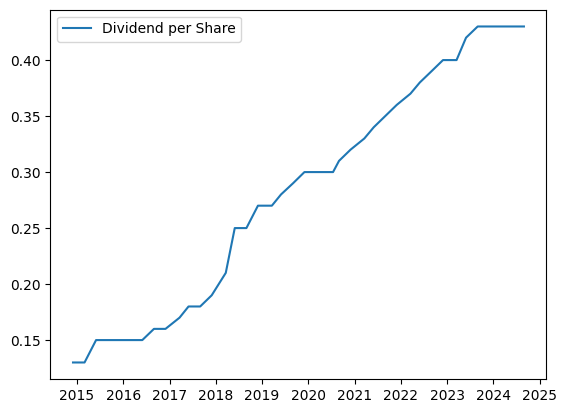

In [33]:
plt.plot(div_events.index, div_events["cash_amount"], label="Dividend per Share")
plt.title = f"Dividend per share of {symbol}"
plt.legend()
plt.show()

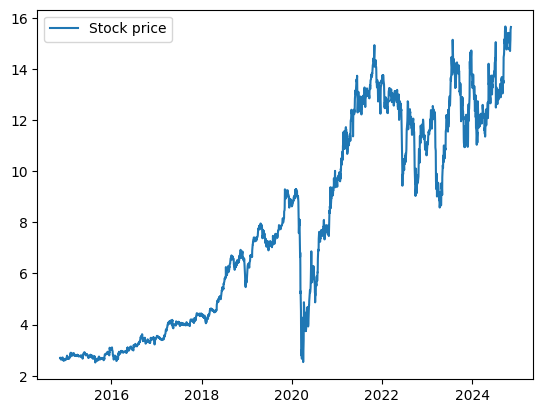

In [34]:
plt.plot(snowball.index, snowball["Close"], label="Stock price")
plt.title = f"Stock Price of {symbol}"
plt.legend()
plt.show()

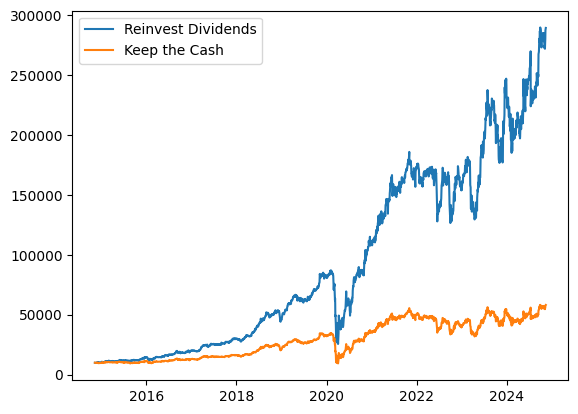

In [35]:
plt.plot(snowball.index, snowball['value'], label='Reinvest Dividends')
plt.plot(dividends_gathered.index, dividends_gathered['value'], label='Keep the Cash')
plt.title = f"Ten year performance {symbol}"
plt.legend()
plt.show()

In [36]:
pd.DataFrame(approaches).set_index("Approach")

,Final Market Amount($),Market Profit($),Market Gain(%),Cash Kept($),Total Profit($),Total Gain(%)
Approach,,,,,,
Reinvest Dividends,289565.35,279565.35,2795.65,0.0,279565.35,2795.65
Keep the Cash,58225.41,48225.41,482.25,42031.0,90256.41,902.56
